In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import missingno
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [2]:
df=pd.read_csv("/content/wine-clustering.csv")
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<Axes: >

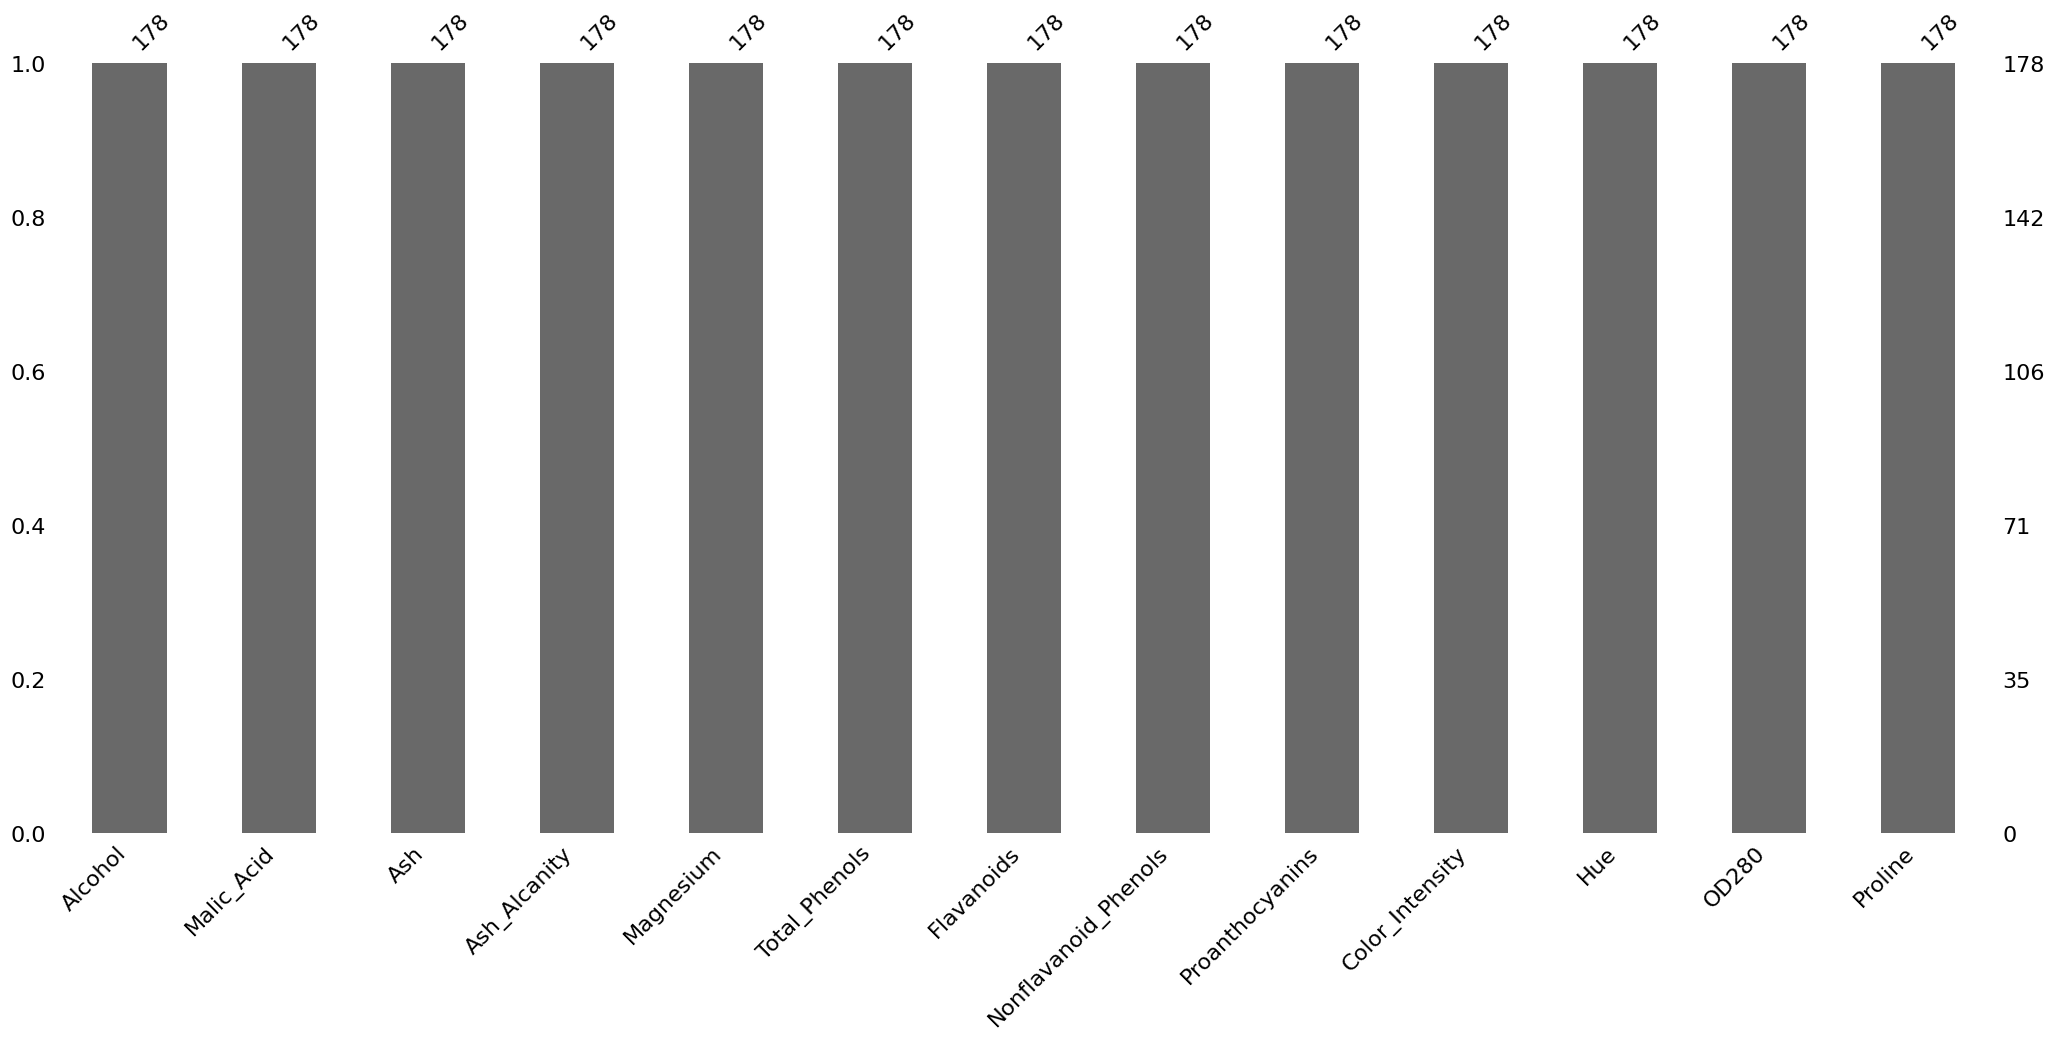

In [3]:
missingno.bar(df)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
Malic_Acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
Ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
Ash_Alcanity,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
Magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
Total_Phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
Flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
Nonflavanoid_Phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
Proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
Color_Intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


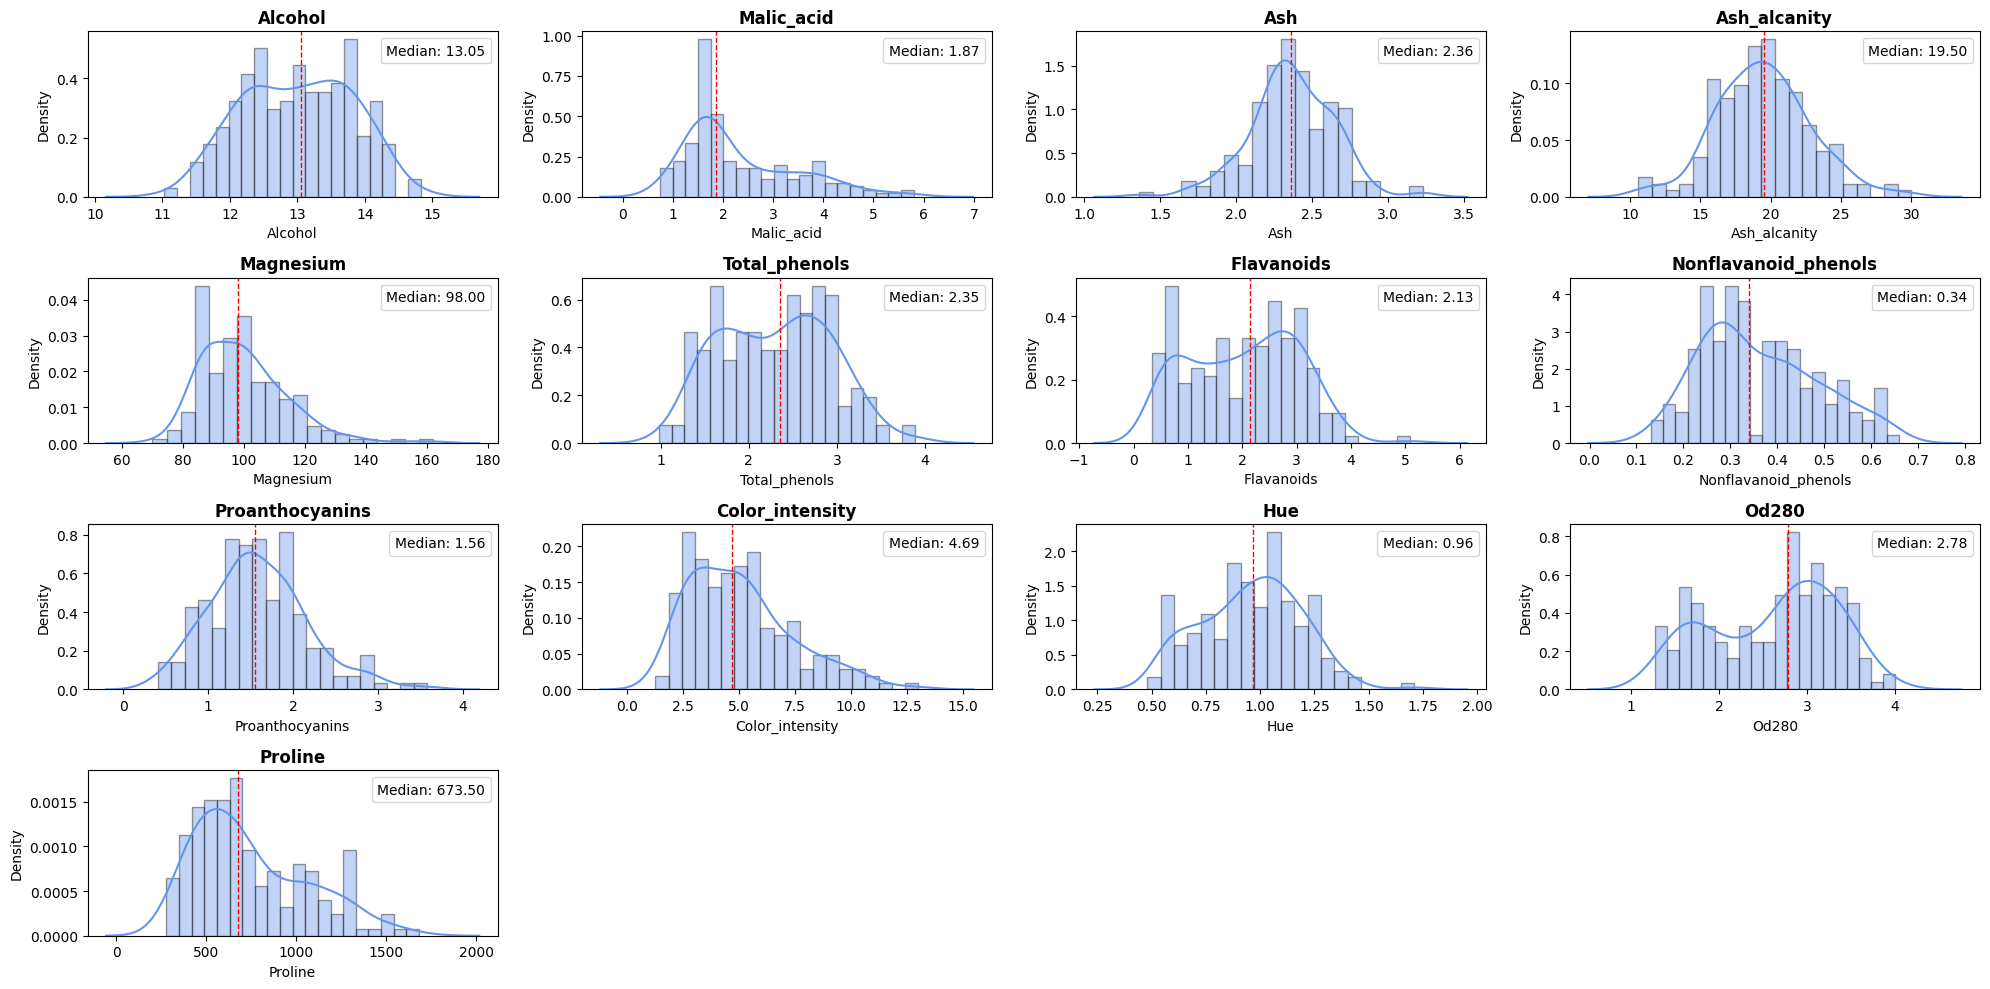

In [6]:
num_cols = [i for i in df.columns if df[i].dtype != "object"]
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
axs = axs.flatten()
for i, col in enumerate(num_cols):
    sns.distplot(df[col], ax=axs[i], color="cornflowerblue", hist_kws=dict(linewidth=1, edgecolor="k"), bins=20)
    axs[i].set_title(col.capitalize(), fontweight='bold')
    axs[i].set_xlabel(col.capitalize())
    median_value = df[col].median()

    axs[i].axvline(x=median_value, color='red', linestyle='--', linewidth=1)
    axs[i].legend([f"Median: {median_value:.2f}"], loc='upper right', handlelength=0, handletextpad=0)
[fig.delaxes(axs) for axs in axs.flatten() if not axs.has_data()]
fig.tight_layout()
plt.show()

<Axes: >

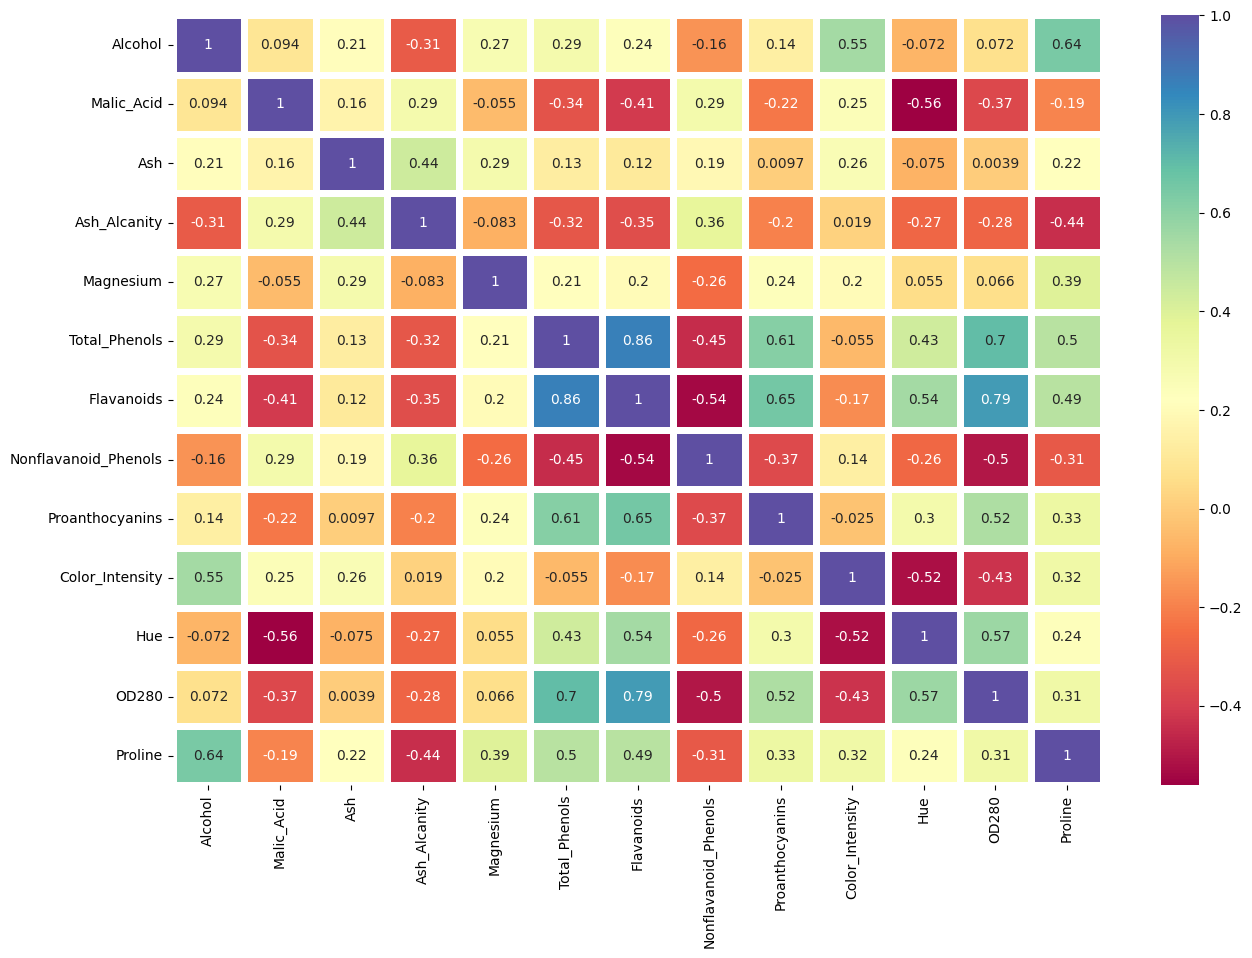

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),cmap="Spectral",annot=True,linewidth=5.)


In [8]:
print("##########################################")

print("OUTLIERS CHECK")
for col in num_cols:
    print(col, check_outlier(df, col))



##########################################
OUTLIERS CHECK
Alcohol False
Malic_Acid True
Ash True
Ash_Alcanity True
Magnesium True
Total_Phenols False
Flavanoids False
Nonflavanoid_Phenols False
Proanthocyanins True
Color_Intensity True
Hue True
OD280 False
Proline False


In [9]:

for col in num_cols:
    replace_with_thresholds(df, col)
print("##########################################")

print("OUTLIERS CHECK")
for col in num_cols:
    print(col, check_outlier(df, col))


##########################################
OUTLIERS CHECK
Alcohol False
Malic_Acid False
Ash False
Ash_Alcanity False
Magnesium False
Total_Phenols False
Flavanoids False
Nonflavanoid_Phenols False
Proanthocyanins False
Color_Intensity False
Hue False
OD280 False
Proline False


In [10]:
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [11]:

scaler = RobustScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
scaled_data = scaler.fit_transform(numeric_cols)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols.columns)
X=scaled_df.values


In [12]:
k = 3
clusters = {}
np.random.seed(23)

for idx in range(k):
    merkez = 2 * (2 * np.random.random((X.shape[1],)) - 1)
    noktalar = []
    cluster = {
        'merkezler': merkez,
        'noktalar': []
    }
    clusters[idx] = cluster

def mesafe(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def merkez_atama(X, clusters):
    for idx in range(X.shape[0]):
        msf = []
        curr_x = X[idx]

        for i in range(k):
            ms = mesafe(curr_x, clusters[i]['merkezler'])
            msf.append(ms)
        ykn_mesafe = np.argmin(msf)
        clusters[ykn_mesafe]['noktalar'].append(curr_x)
    return clusters

def guncelleme_merkez(X, clusters):
    for i in range(k):
        noktalar = np.array(clusters[i]['noktalar'])
        if noktalar.shape[0] > 0:
            yeni_merkez = noktalar.mean(axis=0)
            clusters[i]['merkezler'] = yeni_merkez
            clusters[i]['noktalar'] = []
    return clusters

def tahmin_kumeleme(X, clusters):
    tahmin = []
    for i in range(X.shape[0]):
        msf = []
        for j in range(len(clusters)):
            msf.append(mesafe(X[i], clusters[j]['merkezler']))
        tahmin.append(np.argmin(msf))

    return tahmin

clusters = merkez_atama(X, clusters)
clusters = guncelleme_merkez(X, clusters)
tahmin = tahmin_kumeleme(X, clusters)


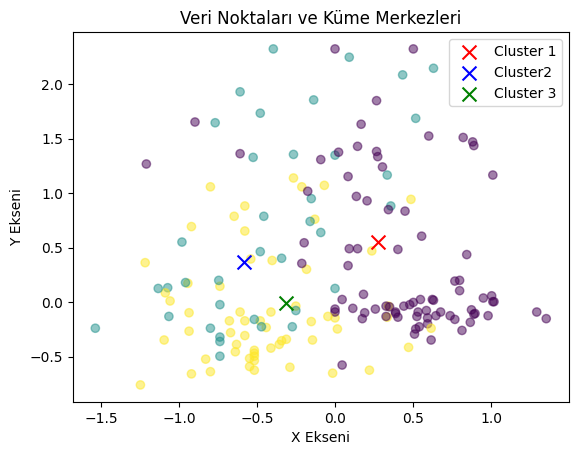

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=tahmin, cmap='viridis', alpha=0.5)
plt.scatter(clusters[0]['merkezler'][0], clusters[0]['merkezler'][1], c='red', marker='x', s=100, label='Cluster 1')
plt.scatter(clusters[1]['merkezler'][0], clusters[1]['merkezler'][1], c='blue', marker='x', s=100, label='Cluster2 ')
plt.scatter(clusters[2]['merkezler'][0], clusters[2]['merkezler'][1], c='green', marker='x', s=100, label='Cluster 3')
plt.xlabel('X Ekseni')
plt.ylabel('Y Ekseni')

plt.legend()
plt.title('Veri Noktaları ve Küme Merkezleri')
plt.show()


['y', 'b', 'g', 'r']


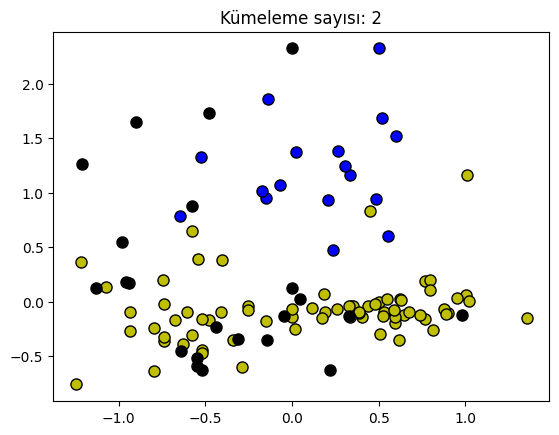

In [14]:
db = DBSCAN(eps=2, min_samples=15).fit(X) # X veri kümesi DBSCAN üzerinde uygulanır.
core_samples  = np.zeros_like(db.labels_, dtype = bool)
core_samples[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # Küme sayısını belirler.
uniq_labels = set(labels)
colors = ['y','b','g','r']
print(colors)

for k, col in zip(uniq_labels, colors):
    if k == -1:
        col= 'k'
    class_member_ara= (labels == k)

    xy = X[class_member_ara & core_samples]

    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k',
            markersize=8)
noise_mask= (labels == -1)
noise_points= X[noise_mask]
plt.plot(noise_points[:,0], noise_points[:,1],'o', markerfacecolor='black',markeredgecolor='black', markersize=8, label='gürültü')
plt.title('Kümeleme sayısı: %d' % n_clusters_)
plt.show()

In [15]:
silhouette = metrics.silhouette_score(X, labels)
print('Silhouette Score: %0.2f' % silhouette)


Silhouette Score: 0.22
